## Load our data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

from imports import *
from structured import *

In [3]:
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from IPython.display import display
from sklearn import metrics

In [4]:
PATH ="data/"

df_raw = pd.read_csv(PATH+'trainx.csv')
df_raw_y = pd.read_csv(PATH+'trainy.csv')

In [5]:
add_datepart(df_raw, 'date_recorded')
train_cats(df_raw)

In [6]:
def func(data):
    if data=='functional':
        return 0
    elif data=='non functional':
        return 1 
    elif data=='functional needs repair':
        return 2

In [7]:
df_raw_y.status_group=df_raw_y.status_group.apply(func)

In [8]:
df_raw['status_group'] = df_raw_y.status_group

In [9]:
df,y,nas = proc_df(df_raw,'status_group')

In [10]:
def split_vals(a,n):
    return a[:n].copy(), a[n:].copy()

In [11]:
n_valid = 17850 # same as the size of test set
n_trn = len(df)- n_valid
x_train, x_val = split_vals(df,n_trn)
y_train, y_val = split_vals(y, n_trn)

In [30]:
x_sub = x_train[['gps_height','date_recordedYear']] 

## Basic data structure

In [31]:
class TreeEnsemble():
    def __init__(self,x,y,n_trees,sample_sz,min_leaf=5):
        np.random.seed(42)
        self.x,self.y,self.sample_sz,self.min_leaf = x,y,sample_sz,min_leaf
        self.trees = [self.create_tree() for i in range(n_trees)]
        
    def create_tree(self):
        # First step is to get a random subsample of data and create a tree
        idxs = np.random.permutation(len(self.y))[:self.sample_sz]
        return DecisionTree(self.x.iloc[idxs],self.y[idxs],
                           idxs=np.array(range(self.sample_sz)),min_leaf=self.min_leaf)
    def predict(self, x):
        return np.mean([t.predict(x) for t in self.trees], axis=0)

In [38]:
class DecisionTree():
    def __init__(self,x,y,idxs=None,min_leaf=5):
        if idxs is None: idxs =  np.arange(len(y))
        self.x,self.y,self.idxs,self.min_leaf = x,y,idxs,min_leaf
        #Let's know how many rows and columns we have
        self.n,self.c = len(idxs),x.shape[1]
        # Next we will require the value: prediction
        self.val = np.mean(y[idxs]) #assume its the mean of all the pediction
        self.score = float('inf') # how effective was the split
        self.find_varsplit()
    
    def find_varsplit(self):
        for i in range(self.c): self.find_better_split(i)
        
    
    def find_better_split(self,var_idx):
        pass
    
    @property
    def split_col(self): return self.x.values[self.idxs,self.var_idx]
    
    @property
    def split_name(self): return self.x.columns[self.var_idx]
    
    @property
    def is_leaf(self): return self.score == float('inf') # Logic: if score is still set to inf it is leaf
    
    def __repr__(self):
        s = f'n: {self.n}; val:{self.val}'
        if not self.is_leaf:
            s+= f';score: {self.score}; split: {self.split}; var:{self.split_name}'
        return s
    
        
        
    

In [39]:
m = TreeEnsemble(x_train,y_train,10,5000)

In [40]:
m.trees[0]

n: 5000; val:0.531

## Single branch

In [41]:
ens = TreeEnsemble(x_sub,y_train,1,1000)
tree = ens.trees[0]
x_samp,y_samp = tree.x,tree.y
x_samp.columns

Index(['gps_height', 'date_recordedYear'], dtype='object')

In [42]:
tree

n: 1000; val:0.52

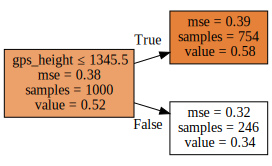

In [43]:
m = RandomForestRegressor(n_estimators=1,max_depth=1,bootstrap=False)
m.fit(x_samp,y_samp)
draw_tree(m.estimators_[0],x_samp,precision=2)

In [44]:
def find_better_split(self,var_idx):
    x,y = self.x.values[self.idxs,var_idx],self.y[self.idxs]
    
    for i in range(1,self.n - 1):
        lhs = x <= x[i]
        rhs = x > x[i]
        if rhs.sum() == 0 : continue
        lhs_std = y[lhs].std()
        rhs_std = y[rhs].std()
        cur_score = lhs_std * lhs.sum() + rhs_std * rhs.sum()
        if cur_score < self.score:
            self.var_idx,self.score,self.split = var_idx,cur_score,x[i]
        
        

In [45]:
%timeit find_better_split(tree,1)
tree

122 ms ± 11.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


n: 1000; val:0.52;score: 615.1375626127908; split: 2012; var:date_recordedYear

In [46]:
%timeit find_better_split(tree,0)
tree

195 ms ± 11.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


n: 1000; val:0.52;score: 608.812209239415; split: 1345; var:gps_height

In [47]:
DecisionTree.find_better_split = find_better_split

In [48]:
tree = TreeEnsemble(x_sub,y_train,1,1000).trees[0];tree

n: 1000; val:0.52;score: 608.812209239415; split: 1345; var:gps_height

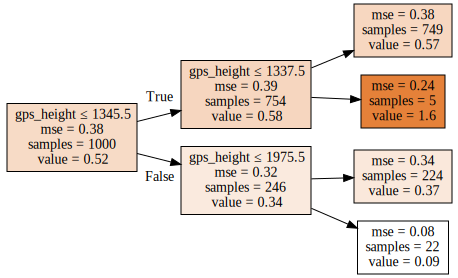

In [49]:
m = RandomForestRegressor(n_estimators=1,max_depth=2,bootstrap=False)
m.fit(x_samp,y_samp)
draw_tree(m.estimators_[0],x_samp,precision=2)

In [50]:
def find_varsplit(self):
    
    for i in range(self.c): self.find_better_split(i)
    x = self.split_col
    lhs = np.nonzero(x<=self.split)[0]
    rhs = np.nonzero(x>self.split)[0]
    self.lhs = DecisionTree(self.x,self.y,self.idxs[lhs])
    self.rhs = DecisionTree(self.x,self.y,self.idxs[rhs])
    

In [51]:
DecisionTree.find_varsplit = find_varsplit

In [52]:
tree = TreeEnsemble(x_sub,y_train,1,1000).trees[0];tree

AttributeError: 'DecisionTree' object has no attribute 'var_idx'

## Try out

In [57]:
class RandomForest:
    def __init__(self,x,y,n_estimator,min_leaf=5):
        self.x,self.y,self.min_leaf = x,y,min_leaf      
        self.trees = [self.createTree() for t in range(n_estimator)]
    
    def createTree(self):
        self.idx = np.random.permutation(len(self.y))
        return DecisionTree(self.x.iloc[self.idx],self.y[self.idx],min_leaf=self.min_leaf)
    
    def predict(self,x):
        return np.mean([t.predict(x) for t in self.trees])

In [ ]:
class DecisionTree:
    def __init__(self,x,y,min_leaf):
        self.x,self.y = x,y
        self.n,self.c = len(self.y),self.x.shape[1]
        self.find_colsplit()
    def find_colsplit(self):
        for i in range(len(idx)): self.find_better_split()
    def find_better_split(self,col_idx):
        x = self.x[:,col_idx]
        for i in
    @property
    def is_leaf(self):
        pass
    @property
    def split_col(self):
        pass
    @property
    def __repr__(self):
        pass
    @property
    def dundant(self):
        return


In [58]:
class Element(object):
    def __init__(self,value):
        self.value = value
        self.next = None

In [70]:
class LinkedList(object):
    def __init__(self,head=None):
        self.head = head
    def append(self,new_element):
        current = self.head
        if self.head:
            while current.next:
                current = current.next
            current.next = new_element
        else:
            self.head = new_element
    def insert(self,new_element,position):
        if position == 1:
            new_element.next = self.head
            self.head = new_element
        else:
            current = self.head
            previous = self.head
            counter = 1
            while counter < position :
                previous = current
                current = current.next
                counter+=1
            previous.next = new_element
            new_element.next = current
    def delete(self,value):
        current = self.head
        previous = None
        if(value == current.value): 
            self.head = current.next
            return
            
        while current.value  != value:
            previous = current
            current = current.next
        previous.next = current.next
        
    def get_position(self, position):
        counter = 1
        current = self.head
        if position < 1:
            return None
        while current and counter <= position:
            if counter == position:
                return current
            current = current.next
            counter += 1
        return None

In [71]:
e1 = Element(1)
e2 = Element(2)
e3 = Element(3)
e4 = Element(4)

In [72]:
ll = LinkedList(e1)
ll.append(e2)
ll.append(e3)

In [73]:
print (ll.head.next.next.value)

3


In [74]:
print (ll.get_position(3).value)

3


In [75]:
# Test insert
ll.insert(e4,3)
# Should print 4 now
print (ll.get_position(3).value)

4


In [76]:
ll.delete(1)
# Should print 2 now
print (ll.get_position(1).value)
# Should print 4 now
print (ll.get_position(2).value)
# Should print 3 now
print (ll.get_position(3).value)

2
4
3


In [ ]:
5/2

In [28]:
def binary_search(input_array, value):
    """Your code goes here."""
    upper = len(input_array)-1
    lower = 0
    found = False
    ind = -1
    while (upper > lower and not found):
        m = (upper + lower)//2
        if (value == input_array[m]):
            ind =  m
            found  = True
        else:
            if(value < input_array[m]):
                upper = m - 1
            else:
                lower = m + 1
        
    return ind

In [34]:
test_list = [1,3,9,11,15,19,29]


%prun print (binary_search(test_list, 15))

-1
 

In [ ]:
%debug

> <ipython-input-26-4f61a4019a3b>(17)binary_search()
     13                 upper = m - 1
     14             else:
     15                 lower = m + 1
     16 
---> 17     return ind

ipdb> lower
4
ipdb> upper
4
ipdb> (upper + lower)// 2
4


In [2]:
5//2

2